In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cmath
from __future__ import division
from sympy import *
from random import randint
from fractions import Fraction

# 1) Fourier Series

#### Find coefficients $\alpha_{k}$ and $\beta_{k}$ as in exercise 1.1

In [2]:
# function values in the grid point (f)
f = [408, 89, -66, 10, 338, 807, 1238, 1511, 1583, 1462, 1183, 804]
N = len(f)

# initialize a and b
a = [0] * (N//2 + 1)
b = [0] * (N//2 - 1)

# compute a_k
for k in range(len(a)):
    for n in range(N):
        a[k] += f[n] * np.cos((2 * np.pi * n * k) / N)
    a[k] /= N
    a[k] *= 2
a[0] /= 2
a[N//2] /= 2

# compute b_k
for k in range(1, len(b)+1):
    for n in range(N):
        b[k-1] += f[n] * np.sin((2 * np.pi * n * k) / N)
    b[k-1] /= N
    b[k-1] *= 2

#### Compute coefficients $c_{k}$ as in exercise 1.2

In [3]:
c = np.array([np.sum([f[l]*cmath.exp(-2*math.pi*k*l*1J/N)/N for l in range(0,N)]) for k in range(0,N//2+1)])

#### Compute fft

In [4]:
def fft(f):
    from scipy.fftpack import fft as unscaled_fft
    return list(map(lambda x : x/len(f), unscaled_fft(f)))

# 2) Analytical Integration

In [5]:
x, y = symbols('x y')
l, i = symbols('l, i', integer=True)
f, g = symbols('f g', cls=Function)

In [6]:
f = -4 * x * (x-1)  # define function
intf = integrate(f, x)  # compute symbolic integration

print(intf)
print()
print(integrate(f,(x, 0, 1)))  # compute integral in dx between 0 and 1

-4*x**3/3 + 2*x**2

2/3


#### Trapezoidal Rule

\begin{equation}T = (b-a)*\frac{f(a)+f(b)}{2}\end{equation}

In [7]:
def trapezoidalRule(f, a, b, n):
    '''
    Implements CTR to approximate the integral of a given function. 
        F ~= T = (b-a) * (f(a)+f(b))/2
    '''
    integral = 0.0
    dh = (b-a)/float(n) # define interval base length
    
    # Calculate the integral.
    # for every interval do...
    for i in range(n):
        l = a + i*dh
        r = l + dh
        integral += dh * (f(l) + f(r)) * 0.5
    
    return integral

integ = trapezoidalRule(lambda t: f.subs(x, t), 0.0, 1.0, 1000)
print('CTR intf =',integ)

CTR intf = 0.666666000000000


#### Simpson Rule

\begin{equation}T = (b-a)*\frac{f(a)+f(b)+4f(\frac{a+b}{2})}{2}\end{equation}


In [8]:
def simpsonRule(f, a, b, n):
    '''
    Implements SR to approximate the integral of given function.
        F ~= S = (b-a) * (f(a) + f(b) + 4*f(m)) / 6, where m = (a+b)/2
    '''
    
    integral = 0.0
    dh = (b-a)/float(n)
    
    # Calculate the integral.
    for i in range(n):
        l = a + i*dh
        r = l + dh
        m = (l + r) * 0.5
    
        integral += dh * (f(l) + f(r) + 4*f(m)) / 6
    
    return integral

integ = simpsonRule(lambda t: f.subs(x, t), 0.0, 1.0, 5)
print('\nSR intf =',integ)


SR intf = 0.666666666666667


## Archimede's Hierarchical Approach 

#### Hierachization of 1d vector

Let $\vec{u} = [u_0,\dots,u_{n-1}]^T \in {\mathbb R}^n, n = 2^l - 1, l \in {\mathbb N}$ a vector of function values with
$u_i = f(x_i = \frac{i + 1}{2^l})$.

The vector $\vec{v}$ contains the hierachical coefficients, computed as \begin{equation} v_{l, i} = u(x_{l,i} - \frac{u(x_{l, i-1})+u(x_{l,i+1})}{2} \end{equation}

OSS: When computing $\vec{v}$ is important to start from maxlevel and go back to level 0, while when computing the values $\vec{u}$ from $\vec{v}$ the formula is the inverse, but also the order is from level 0 to maxlevel!

In [9]:
def hierarchize1d(u, maxlv):
    ''' 
    Basic algorithm:
    -----------------
    for l = maxlevel..1 :
        delta = 2**(maxl - l)   # detla is indeed the index interval between mid-point and end-point
        for j = index of every point of level l:
            v[j] = u[j] - 0.5*(u[j-delta] + u[j+delta])  
    '''
    
    v = list(u)
    N = len(u)
    
    for lv in range(maxlv, 1, -1):   # no need to include level=1, bc v[j] = u[j] at level 1
        delta = 2**(maxlv - lv)      # index interval between mid-point and end-point
        first = 2**(maxlv - lv) - 1  # first point index of current level
        
        for j in range(first, N, 2*delta):
            #v[j] = u[j] - 0.5 * (u[j-delta] + u[j+delta]) <--- cannot do this directly
            # we need to make sure index not out of bound
            
            v[j] = u[j]
            
            if (j-delta >= 0):
                v[j] -= 0.5 * u[j-delta]
                
            if (j+delta < N):
                v[j] -= 0.5 * u[j+delta]
    
    return v

In [10]:
def dehierarchize1d(v, maxlv):
    ''' 
    Basic algorithm:
    -----------------
    for l = 1..maxlevel :
        delta = 2**(maxl - l)   # detla is indeed the index interval between mid-point and end-point
        for j = index of every point of level l:
            u[j] = v[j] + 0.5*(v[j-delta] + v[j+delta])  
    '''
    
    u = list(v)
    N = len(v)
    
    #ToDo
    for l in range(1, maxlv+1):
        delta = 2**(maxlv - l)
        start = delta - 1
        for i in range(0, 2**l - 1, 2):
            position = start + i * delta
            assert(N > position >= 0)
            u[position] = v[position]
            if position - delta >= 0:
                u[position] += 0.5 * u[position - delta]
            if position + delta < N:
                u[position] += 0.5 * u[position + delta]
    return u

# 3) Wavelets

#### Cascade Algorithm

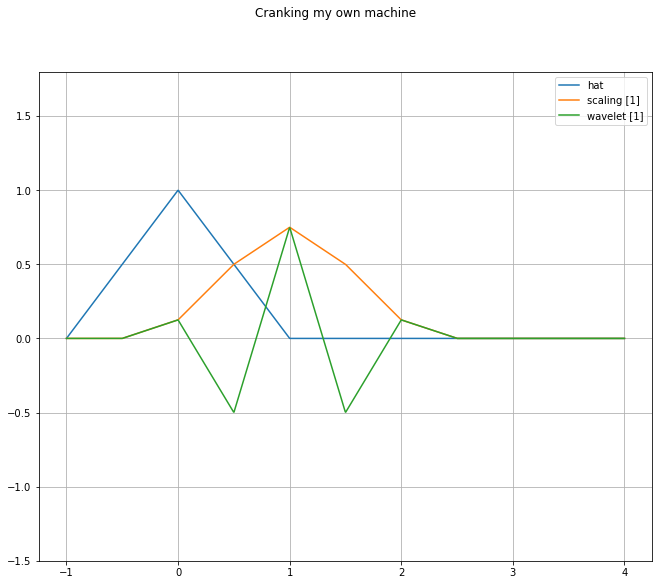

In [11]:
# --- Coefficents ---

class HaarScalingFunction:
    c = (1.0, 1.0)
    
class Daubechies4ScalingFunction:
    c = (0.683012701892, 1.18301270189, 0.316987298108, -0.183012701892)
    
class BattleLemarieScalingFunction:
    c = (1/8, 1/2, 3/4, 1/2, 1/8)
    
# ---------------------

# Father Wavelet (scaling function)
class FixedPointScalingApproximation:
    def __init__(self, previous_scaling, c):
        self.previous_scaling = previous_scaling
        self.c = c
        self.N = len(c)
    def __call__(self, x):
        c = self.c
        result = 0.0
        for i in range(self.N):
            result += c[i] * self.previous_scaling(2*x - i)
        return result

# Mother Wavelet    
class FixedPointWaveletApproximation:
    def __init__(self, previous_scaling, c):
        self.previous_scaling = previous_scaling
        self.c = c
        self.N = len(c)
    def __call__(self, x):
        c = self.c
        result = 0.0
        for i in range(self.N):
            result += (-1)**i * c[self.N-i-1] * self.previous_scaling(2*x - i)
        return result
    
#ScalingFunction = HaarScalingFunction
#ScalingFunction = Daubechies4ScalingFunction
ScalingFunction = BattleLemarieScalingFunction

a, b =  -1.0, 4.0
plotLevel  = 8
itermax = 1

fig = plt.figure(1, figsize = (11, 9))
plt.suptitle('Cranking my own machine')
_ = plt.grid(True)
_ = plt.ylim(-1.5, 1.8)

# starting point in the fixed point iteration
hat = lambda t: max(0.0, 1-abs(t))

# set of sampling points used for plotting
x = np.linspace(a, b, int(b-a) << plotLevel)

# plot the hat function
ax = []
ax.append(plt.plot(x, list(map(hat, x)), label="hat"))

# Output scaling functions (father)
fixedPointScaling = [hat,] + [None,]* itermax

# Output wavelet functions (mother)
fixedPointWavelet = [hat,] + [None,]* itermax

for i in range(1, itermax + 1):
    fixedPointScaling[i] = FixedPointScalingApproximation(fixedPointScaling[i-1], ScalingFunction.c)
    fixedPointWavelet[i] = FixedPointWaveletApproximation(fixedPointScaling[i-1], ScalingFunction.c)    


ax.append(plt.plot(x, list(map(fixedPointScaling[itermax], x)), label="scaling [%d]" % itermax))
ax.append(plt.plot(x, list(map(fixedPointWavelet[itermax], x)), label="wavelet [%d]" % itermax))

_ = plt.legend()
_ = plt.show()



In [12]:
#### Haar Wavelet Transformation Matrix
def buildHaarWaveletTransformationMatrix(level, inverse=False):
    '''
    Haar Wavelet Transform as dense matrix

    @param level matrix dimensions are (2^level x 2^level)
    @param normalized build orthogonal matrix
    @param inverse build the inverse transformation matrix
    '''
    M = np.zeros((2**level,2**level))

    for i in range(2**level):
        M[i,0] = 1
    j = 1
    for l in range(1,level+1):
        for j_level in range(2**(l-1)):
            delta = 2**(level - l)
            start = 2 * delta * j_level
            end = start + delta
            for i in range(start,end):
                M[i,j] = 1
            for i in range(start+delta,end+delta):
                M[i,j] = -1
            j += 1
    
    if inverse:
        return np.linalg.inv(M)
    return M

M = buildHaarWaveletTransformationMatrix(3, False)
M_inv = buildHaarWaveletTransformationMatrix(3, True)

In [13]:
# Input signal vector
s = np.array([1.0, 2.0, 3.0, -1.0, 1.0, -4.0, -2.0, 4.0])
print('Input signal: ',s)

d = np.array(np.dot(M_inv,s.transpose()))
print('Result from Matrix transformation: ',d)

ss = np.array(np.dot(M, d.transpose()))
print('Resutl from reversed Matrix transforamtion: ',ss.transpose())

Input signal:  [ 1.  2.  3. -1.  1. -4. -2.  4.]
Result from Matrix transformation:  [ 0.5   0.75  0.25 -1.25 -0.5   2.    2.5  -3.  ]
Resutl from reversed Matrix transforamtion:  [ 1.  2.  3. -1.  1. -4. -2.  4.]


#### Low and High Pass with all the printing statements

In [14]:
def low_pass(x):
    result = []
    for i in range(0, len(x), 2):
        result.append((x[i]+x[i+1])/2)
    return result

def high_pass(x):
    result = []
    for i in range(0, len(x), 2):
        result.append((x[i]-x[i+1])/2)
    return result

def BasisTransform(x):
    """
    x must be a vector of length 2^n
    """
    level = math.log(len(x), 2)
    assert(level.is_integer())
    level = int(level)
    c = x.copy()
    print(f'c({level}): {c}\n')
    result = []
    while len(c) > 1:
        d = high_pass(c)
        for el in d[::-1]:
            result.insert(0, el)
        c = low_pass(c)
        level = int(math.log(len(c), 2))
        print(f'c({level}): {c}')
        print(f'd({level}): {d}\n')
    result.insert(0, c[0])
    print(f'Transformation: {result}')

In [15]:
x = [1, 2, 3, -1, 1, -4, -2, 4]

BasisTransform(x)

c(3): [1, 2, 3, -1, 1, -4, -2, 4]

c(2): [1.5, 1.0, -1.5, 1.0]
d(2): [-0.5, 2.0, 2.5, -3.0]

c(1): [1.25, -0.25]
d(1): [0.25, -1.25]

c(0): [0.5]
d(0): [0.75]

Transformation: [0.5, 0.75, 0.25, -1.25, -0.5, 2.0, 2.5, -3.0]


# 4) Multidimensional Quadrature

#### Step 0) Define dimensions, level and function

In [16]:
x1, x2 = symbols('x1 x2')

d = 2
l = 3
f = 16*x1 * (x1-1) * x2 * (x2-1)

#### Step 1) Compute Surpluses

In [17]:
def f_value(value_x, value_y, f=f):
    return f.subs(x1, value_x).subs(x2, value_y)


def hierarchize1d(u):
    maxlv = int(np.ceil(np.log2(len(u))))
    v = list(u)
    N = len(u)
    
    for lv in range(maxlv, 1, -1):  # no need to include level=1 because v[j] = u[j] at level 1
        delta = 2**(maxlv - lv)  # index interval between mid-point and end-point
        first = delta - 1  # first point index of current level
        
        for j in range(first, N, 2*delta):
            v[j] = u[j]
            if j-delta >= 0:
                v[j] -= 0.5 * u[j-delta]
            if j+delta < N:
                v[j] -= 0.5 * u[j+delta]
    
    return v

def compute_surpluses(xlevel=3, ylevel=3, f=f):
    # create grid
    x = np.linspace(0, 1, 2**xlevel + 1)[1:-1]
    y = np.linspace(0, 1, 2**ylevel + 1)[1:-1]

    X, Y = np.meshgrid(x, y)
    dim_x = len(x)
    dim_y = len(y)
    
    
    # compute values of the function for each value
    U = np.zeros((dim_x, dim_y))
    for i in range(len(x)):
        for j in range(len(y)):
            U[i][j] = f_value(x[i], y[j], f=f)
    
    # for each row of U, compute the 1d hierarchized values!
    V_tmp = np.zeros((dim_x, dim_y))
    for i in range(U.shape[0]):
        V_tmp[i, :] = hierarchize1d(U[i, :])

    # for each column of the new computed matrix, compute the 1d hierachized values
    V = np.zeros((dim_x, dim_y))
    for i in range(V_tmp.shape[1]):
        V[:, i] = hierarchize1d(V_tmp[:, i])
    
    return V

#### Step 2) Compute base area of associated pagodas

For each grid point $x_{l,i}$ the base area is $2^{-|l|_{1}}$

In [18]:
def compute_pagoda_areas(xlevel=3, ylevel=3):
    # create grid
    x = np.linspace(0, 1, 2**xlevel + 1)[1:-1]
    y = np.linspace(0, 1, 2**ylevel + 1)[1:-1]
    X, Y = np.meshgrid(x, y)
    dim_x = len(x)
    dim_y = len(y)
    
    # define level based on indeces
    # if a grid point is located on position (3, 2) it means that it is level (1, 3)
    # D_levels = {3: 1, 1:2, 5:2, 0:3, 2:3, 4:3, 6:3}
    D_levels = {}
    for lv in range(0, xlevel+1): 
        delta = 2**(xlevel - lv)  
        first = delta - 1 
        for j in range(first, dim_x, 2*delta):
            D_levels[j] = lv
            
                
    # compute values of pagoda volumes for each grid point
    base_areas = np.zeros((dim_x, dim_y))
    for i in range(dim_x):
        for j in range(dim_y):
            base_areas[i][j] = 2**(-(D_levels[i] + D_levels[j]))
            
    return base_areas

#### Step 3) Compute volumes of associated pagodas by multiplying base areas and surpluses

In [19]:
def compute_pagoda_volumes(base_areas, surpluses, thresh=0.):
    volumes = np.zeros_like(base_areas)
    for i in range(volumes.shape[0]):
        for j in range(volumes.shape[1]):
            volumes[i][j] = base_areas[i, j] * surpluses[i, j]
            if volumes[i][j] < thresh:
                volumes[i][j] = 0.
            
    return volumes

#### Step 4) Compute final volume

In [20]:
def compute_volume(volumes):
    return np.sum(volumes)

#### Step 5) Put everything together

In [21]:
def pagoda_volumes(xlevel=l, ylevel=l, f=f, thresh=0., colors=None):
    # get data
    surpluses = compute_surpluses(xlevel=xlevel, ylevel=ylevel, f=f)
    base_areas = compute_pagoda_areas(xlevel=xlevel, ylevel=ylevel)
    volumes = compute_pagoda_volumes(base_areas=base_areas, surpluses=surpluses, thresh=thresh)
    tot_volume = compute_volume(volumes)
    tot_non_null = np.count_nonzero(volumes)
    
    # plot
    x = np.linspace(0, 1, 2**xlevel + 1)
    y = np.linspace(0, 1, 2**ylevel + 1)
    X, Y = np.meshgrid(x, y)
    padded_volumes = np.pad(volumes, pad_width=1)
    if colors is None:
        colors = []
        n = len(np.unique(padded_volumes))
        for i in range(n):
            colors.append('#%06X' % randint(0, 0xFFFFFF))
    assert (len(colors) == len(np.unique(padded_volumes)))
    
    # associate value to color
    D_colors = {}
    for i in range(len(np.unique(padded_volumes))):
        D_colors[np.unique(padded_volumes)[i]] = colors[i]

    # create new volumes array with color encoding
    volumes_colors = np.empty_like(padded_volumes, dtype=object)
    for i in range(padded_volumes.shape[0]):
        for j in range(padded_volumes.shape[1]):
            volumes_colors[i][j] = D_colors[padded_volumes[i, j]]
            
    # finalize the plot
    fig = plt.figure(figsize=(8, 8))

    for i in range(len(X)):
        for j in range(len(Y)):
            plt.scatter(x[i], y[j], c=volumes_colors[i, j])
    
    labels = [Fraction(x) for x in list(D_colors.keys())]
    ax = plt.gca()
    plt.legend(labels, fancybox=True, framealpha=0.3)
    leg = ax.get_legend()
    for i in range(len(D_colors.keys())):
        leg.legendHandles[i].set_color(list(D_colors.values())[i])

    plt.ylim(0, 1)
    plt.xlim(0, 1)
    ax.set_yticks(y)
    ax.set_xticks(x)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    plt.suptitle(f'Total Volume: {tot_volume}', y=0.95)
    plt.title(f'Threshold: {thresh}, N° of Pagodas: {tot_non_null}')
    plt.show()

#### Step 6) Run it!

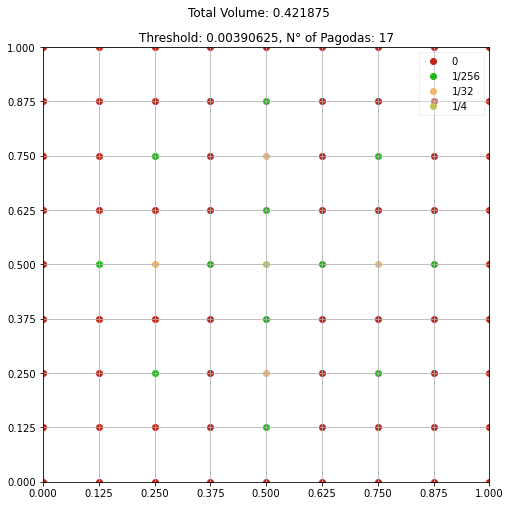

In [22]:
d = 2
l = 3
f = 16*x1 * (x1-1) * x2 * (x2-1)

pagoda_volumes(thresh=1/256)

# 5) Space Filling Curves

#### Compute base 4 and base 9 representations

In [23]:
def base4(x):
    Q = []
    init_value = int(x // 4)
    it = 0
    while x != 0 and it < 20:
        x *= 4
        q, r = divmod(x, 4)
        Q.append(int(q))
        x = r
        it += 1
    Q = [str(el) for el in Q]
    return '0.' + ''.join(Q[1:])

def base9(x):
    Q = []
    init_value = int(x // 9)
    it = 0
    while x != 0 and it < 20:
        x *= 9
        q, r = divmod(x, 9)
        Q.append(int(q))
        x = r
        it += 1
    Q = [str(el) for el in Q]
    return f'{init_value}.' + ''.join(Q[1:])

In [24]:
base9(1/2)

'0.4444444444444444444'

In [25]:
base4(1/3)

'0.1111111111111111111'